In [13]:
import numpy as np

def bezier(points, precision):
    """Função que cria as curvas Bezier         

    Parâmetros:
    -----------
    points: ndarray
        vetor que contém os pontos de controle
    precision: int
        número de pontos que serão criados entre o ponto inicial e final
    Retorno:
    -----------
    B: ndarray
        Armazena os valores acumalados das contribuições dos pontos de controle ponderados pelos coeficientes de Bernstein.      
    """    
    # gera a quantidade de números no intervalo de 0 e 1, dependendo do valor de precision.
    ts = np.linspace(0, 1, precision)    
    # gera uma matriz com duas colunas e a quantidade de linhas dependendo do tamanho de ts (de zeros), com o tipo float
    result = np.zeros((len(ts), 2), dtype=np.float64)   
    n = len(points) - 1
    
    for idx, t in enumerate(ts):        
        for i in range(n+1):
            # o coeficiente binomial é usado para ponderar a influência de cada ponto de controle na curva final  
            bin_coef = np.math.factorial(n) / (np.math.factorial(i) * np.math.factorial(n-i))

            # termos polinômio de Bernstein
            Pin = bin_coef * (1-t)**(n-i) * t**i
            
            # cada índice de B recebe a multiplicação do resultado das ponderações de cada coeficiente
            result[idx] += Pin * points[i]   
    return result

# elemento utilizado para não ultrapassar a borda
padding = 20

def criando_pontos(tam):
    """ Função que cria pontos aleatórios (coordenadas) no plano, tendo como base a quantidade de pontos desejados(tam) entre uma 
      distância Euclidiana mínima e máxima estipuladas

    Parâmetros:
    -----------
    tam: int
        valor que determina a quantidade de pontos aleatórios que serão gerados    
    Retorno:
    -----------
    points: ndarray float
        Armazena os pontos.
    distancia: float
        armazena o valor da distância entre o ponto inicial e final
    """    

    #teste
    n_linhas = 800
    n_colunas = 800

    points = []    
    while len(points)<tam:
        # sorteio dos pontos
        p1x = np.random.randint(0,n_colunas-padding)   
        p1y = np.random.randint(0,n_linhas-padding)   
        p2x = np.random.randint(0,n_colunas-padding) 
        p2y = np.random.randint(0,n_linhas-padding) 

        # distância Euclidiana entre as coordenadas inicial e final
        distancia = np.sqrt((p1x-p2x)**2 + (p1y-p2y)**2)

        # só acrescenta no array de pontos elementos cuja distância seja maior que 500 pixels e menor que 1300
        if distancia > 300 and distancia < 500:
        #if distancia > 500 and distancia < 1300:
            p1 = np.array((p1x,p1y))
            p2 = np.array((p2x,p2y))

            # empilha os pontos
            p = np.vstack((p1, p2))        
            points.append(p)
            
    # retorna os pontos criados ao longo do traçado e a distância. O elemento distância servirá de base para estipular
    # o comprimento (quantidade de colunas) dos mapas transformados.
    return points, distancia

def criar_array_curves(pontos):
    array_curves = []
    ps = pontos[0][0] # ponto inicial   
    pe = pontos[0][1] # ponto final 
    dx = pe[0]-ps[0]
    dy = pe[1]-ps[1]
    distancia = np.sqrt((pe[0]-ps[0])**2 + (pe[1] - ps[1])**2)
    normal_se = np.array((-dy, dx))/distancia #ou (dy, -dx) --> vetor normal à (pe-ps)
    max_vd = 100 # distancia máxima em que os pontos de controle serão sorteados. Exemplo: 1 gera traçados retos. Usar números maiores que 100.
    n_points = 6 # numero de pontos de controle entre pe e ps. Quanto maior esse número mais curvas são geradas.

    control_points = []
    hds = np.linspace(0.2, 0.8, n_points) # faz com que os pontos de controle sejam equidistantes em relação à (pe-ps)

    for j in range(n_points):            
        control_point = ((pe-ps) * hds[j]) # setar as distancias horizontais dessa maneira deixa um aspecto mais natural
        control_point += (normal_se * np.random.uniform(low=-1, high=1) * max_vd)
        control_points.append(control_point+ps)

    control_points.insert(0, ps)
    control_points.append(pe)
    curve = bezier(control_points, precision=100)       
    array_curves.append(curve)        
    return array_curves 

In [20]:
from matplotlib import pyplot as plt
import sys
#linux
sys.path.insert(0, "/home/adriano/projeto_mestrado/modules/")

from Funcoes_gerais import funcoes
from pathlib import Path

#linux
sys.path.insert(0, "/home/adriano/projeto_mestrado/modules/")

#windows
#sys.path.insert(0, r"C:\Users\adria\Documents\Mestrado\texture_codes\modules")

# linux
root_dir = f"/home/adriano/projeto_mestrado/modules"

# windows
#root_dir = Path(r"C:\Users\adria\Documents\Mestrado\texture_codes\modules")

tracados_bezier = f'{root_dir}/Artificial_Lines/tracados_bezier_testes/'

array_curves = []
for i in range(5): 
    pontos, distancia = criando_pontos(25)
    curve = criar_array_curves(pontos)
    dict = {
        "curve": curve,
        "distancia": distancia
    }
    curve.append(distancia)   
    funcoes.gravar_dict_arquivo(dict,f'{tracados_bezier}/img_savedata_{i}.json')
    array_curves.append(curve)

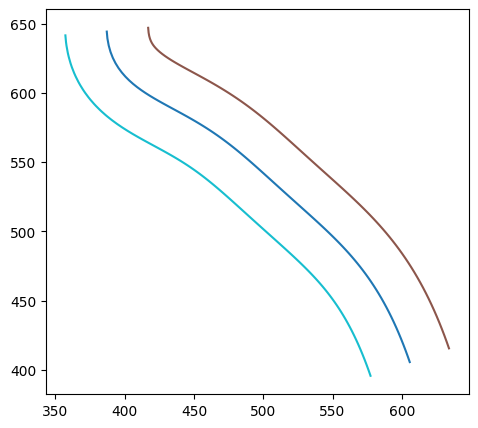

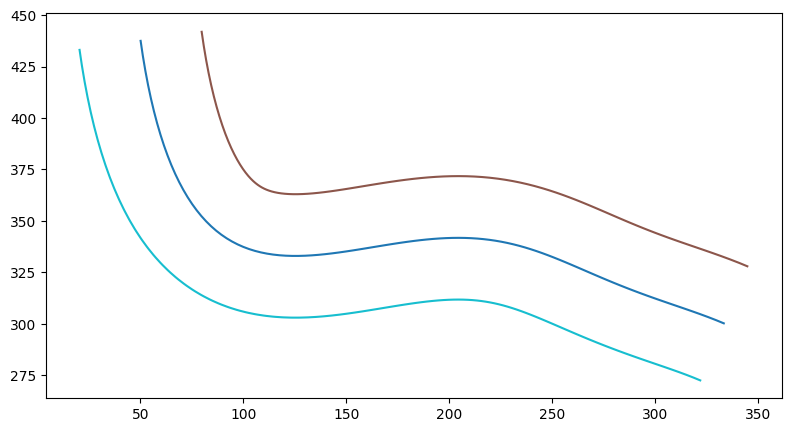

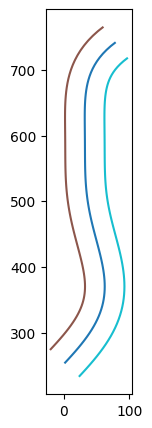

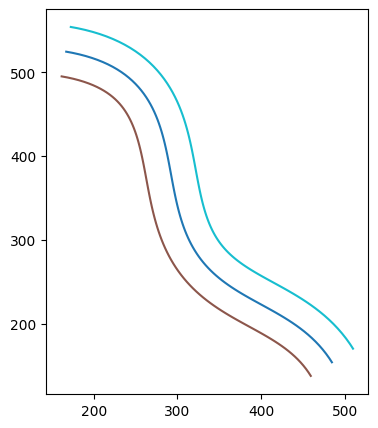

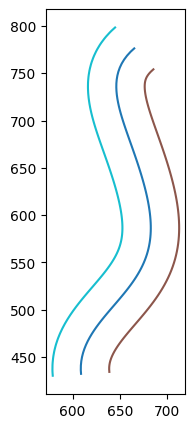

In [21]:
from Background import background_generation as backgen
from geopandas import gpd

for i in range(len(array_curves)):    

    linha_central,linha_offset_esquerda,linha_offset_direita, maior_tamanho = backgen.retorna_linhas_offset_posicao_tamanho(array_curves[i][0],30)   
    fig, ax2 = plt.subplots(figsize=(10,5))
    gp4 = gpd.GeoSeries([linha_offset_esquerda, linha_central, linha_offset_direita])   
    gp4.plot(ax=ax2, cmap="tab10")   
    fig.savefig(f'{root_dir}/Artificial_Lines/LineStrings/varios_pontos_controle/tracado_{i}.svg', format='svg')
